In [1]:
# импортируем необходимые библиотеки, 
# модули, классы и функции
import pandas as pd
import numpy as np
import optuna
import random
from functools import partial

# импортируем из библиотеки etna нужные классы
from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import (LagTransform,
                             LogTransform,
                             MeanTransform,
                             DateFlagsTransform,
                             LinearTrendTransform,
                             SegmentEncoderTransform,
                             StandardScalerTransform)

# импортируем функцию plot_forecast()
# для визуализации прогнозов
from etna.analysis import plot_forecast

# увеличиваем максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', 250)

# импортируем модуль предупреждений
import warnings
# включим игнорирование предупреждений
warnings.filterwarnings('ignore')

from IPython.display import display

In [2]:
# функция установки начального значения 
# генератора псевдослучайных чисел
def set_seed(seed=42):
    # установка генератора случайных чисел Python 
    random.seed(seed)
    # установка генератора случайных чисел NumPy
    np.random.seed(seed)

## Оптимизация гиперпараметров с выделением отдельной тестовой выборки

In [3]:
# целевая функция Optuna
def objective(trial, ts, horizon, metrics, metric_name, n_folds, depth, 
              lag_upper_bound, lag_step, window_size,
              print_configurations, print_metrics, seed):

    # установка начального значения генератора случайных чисел 
    set_seed(seed)
    
    # создаем экземпляр класса LogTransform для логарифмирования 
    # зависимой переменной
    log = LogTransform(in_column='target')
    
    # создаем экземпляр класса StandardScalerTransform
    # для стандартизации зависимой переменной
    scaler = StandardScalerTransform('target')
    
    # создаем экземпляр класса LinearTrendTransform для прогнозирования 
    # тренда, удаления тренда из даннных и добавления тренда к прогнозам
    detrend = LinearTrendTransform(in_column='target')

    # создаем экземпляр класса SegmentEncoderTransform для 
    # кодирования меток сегментов целочисленными значениями 
    # в лексикографическом порядке (LabelEncoding): сегменты
    # a, b, c, d получат значения 0, 1, 2, 3
    seg = SegmentEncoderTransform()
    
    # создаем экземпляр класса LagTransform для генерации лагов
    lag = LagTransform(
        in_column='target', 
        lags=list(
            range(horizon, 
                  trial.suggest_int('lag_upper_bound', 100, lag_upper_bound), 
                  trial.suggest_int('lag_step', 5, lag_step)
                 )
        )
    )
    
    # создаем экземпляр класса MeanTransform 
    # для генерации скользящих средних
    mean = MeanTransform(
        in_column='target', 
        window=trial.suggest_int('window_size', horizon, window_size)
    )
       
    # создаем экземпляр класса DateFlagsTransform
    # для генерации признаков на основе дат
    d_flags = DateFlagsTransform(day_number_in_week=True,
                                 day_number_in_month=True,
                                 month_number_in_year=True,
                                 season_number=True,
                                 is_weekend=True, 
                                 out_column='datetime')
    
    transforms = [log, scaler, detrend, seg, lag, mean, d_flags]
    
    #  создадим экземпляр Pipeline
    pipeline = Pipeline(
        # определим модель
        model = CatBoostMultiSegmentModel(
            iterations=500,
            depth=trial.suggest_int('depth', 3, depth)
        ),
        # определим список трансформеров
        transforms=transforms,
        # установка горизонта для прогнозов
        horizon=horizon
    )
    
    # печатаем конфигурацию гиперпараметров
    if print_configurations:
        print(f'\nконфигурация:\n{pipeline}')

    # запускаем перекрестную проверку с подсчетом метрик
    df_metrics, _, _ = pipeline.backtest(ts=ts, metrics=[metrics], 
                                         n_folds=n_folds,
                                         aggregate_metrics=True)
    
    # печатаем метрики
    if print_metrics:
        print(f'метрика по сегментам:\n{df_metrics}')
    
    # возвращаем средние значения по найденным метрикам
    return df_metrics[metric_name].mean()

In [4]:
# функция, создающая обучающий и тестовый наборы
def train_test_dataloader(internal_hist_path,
                          external_hist_path,
                          horizon=90,
                          freq='D',
                          verbose=False):
    
    # загружаем исторические данные о продажах
    hist_sales = pd.read_csv(internal_hist_path, 
                             index_col=['date'], 
                             parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о продажах')
        display(hist_sales)
    
    # загружаем исторические данные о рекламной активности
    hist_advert = pd.read_csv(external_hist_path, 
                              parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о рекламной активности')
        display(hist_advert)
        
    # заполним пропуски в исторических рядах продаж
    # с помощью линейной интерполяции
    for col in hist_sales.columns.tolist():
        hist_sales[col] = hist_sales[col].interpolate(method='linear')
        
    if verbose:
        print('заполним пропуски в исторических данных о продажах ' 
              'с помощью линейной интерполяции')
        display(hist_sales)
        
    # формируем обучающий набор продаж
    train_sales = hist_sales.iloc[:-horizon]
    
    if verbose:
        print('формируем обучающий набор продаж')
        display(train_sales)
        
    # отбираем наблюдения с 2013 года и сбрасываем прежний индекс
    # в исторических данных о рекламной активности
    train_sales = train_sales[train_sales.index >= '2013-01-01']
    hist_advert = hist_advert[hist_advert['date'] >= '2013-01-01'].reset_index(
        drop=True)
    
    if verbose:
        print('отбираем наблюдения с 2013 года и сбрасываем прежний \n'
              'индекс в исторических данных о рекламной активности')
        display(train_sales, hist_advert)
        
    # выделим столбец с датой в обучающем наборе продаж
    train_sales['timestamp'] = train_sales.index
    # сбрасываем прежний индекс
    train_sales = train_sales.reset_index(drop=True)
    
    if verbose:
        print('выделим столбец с датой в обучающем наборе продаж '
              'и сбросим прежний индекс')
        display(train_sales)
           
    # расплавляем обучающий набор продаж в длинный датафрейм
    train_sales_melt = train_sales.melt(id_vars='timestamp', 
                                        var_name='segment', 
                                        value_name='target')
    
    if verbose:
        print('расплавляем обучающий набор продаж в длинный датафрейм')
        display(train_sales_melt)
        
    # переводим обучающий набор продаж в формат ETNA
    train_ts_format = TSDataset.to_dataset(train_sales_melt)    
    
    if verbose:
        print('переводим обучающий набор продаж в формат ETNA')
        display(train_ts_format)
        
    # переименовываем date в timestamp в исторических 
    # данных о рекламной активности
    hist_advert.rename(columns={'date': 'timestamp'}, inplace=True)
    # расплавляем исторические данные о рекламной 
    # активности в длинный датафрейм
    hist_advert_melt = hist_advert.melt(id_vars='timestamp', 
                                        var_name='segment', 
                                        value_name='advert')
    
    if verbose:
        print('переименовываем date в timestamp в исторических данных '
              'о рекламной активности и расплавляем в длинный датафрейм')
        display(hist_advert_melt)
    
    # создаем переменную - квартал
    hist_advert_melt['quarter'] = hist_advert_melt[
        'timestamp'
    ].dt.quarter
    # создаем переменную - начало квартала
    hist_advert_melt['quarter_start'] = hist_advert_melt[
        'timestamp'
    ].dt.is_quarter_start
    # создаем переменную - конец квартала
    hist_advert_melt['quarter_end'] = hist_advert_melt[
        'timestamp'
    ].dt.is_quarter_end
    # создаем переменную - название месяца
    hist_advert_melt['month_name'] = hist_advert_melt[
        'timestamp'
    ].dt.strftime('%b')
    hist_advert_melt['month_name'] = hist_advert_melt[
        'month_name'
    ].astype('category')
    
    if verbose:
        print('создаем календарные признаки в исторических данных '
              'о рекламной активности')
        display(hist_advert_melt)
    
    # переводим набор с экзогенными переменными (рекламная активность,
    # календарные признаки) в формат ETNA
    hist_regressors_ts_format = TSDataset.to_dataset(hist_advert_melt)
    
    if verbose:
        print('переводим набор с экзогенными переменными (рекламная '
              'активность, календарные признаки) в формат ETNA')
        display(hist_regressors_ts_format)
    
    # создаем итоговый обучающий набор как объект TSDataset
    train_ts = TSDataset(
        train_ts_format, freq=freq, 
        df_exog=hist_regressors_ts_format, known_future='all')
    
    if verbose:
        print('создаем итоговый обучающий набор как объект TSDataset')
        display(train_ts)
        
    # формируем тестовый набор продаж
    test_sales = hist_sales.iloc[-horizon:]
    
    if verbose:
        print('формируем тестовый набор продаж')
        display(test_sales)
        
    # выделим столбец с датой
    test_sales['timestamp'] = test_sales.index
    # сбрасываем прежний индекс
    test_sales = test_sales.reset_index(drop=True)
    
    if verbose:
        print('выделим столбец с датой в тестовом наборе продаж '
              'и сбросим прежний индекс')
        display(test_sales)
        
    # расплавляем тестовый набор продаж в длинный датафрейм
    test_sales_melt = test_sales.melt(id_vars='timestamp', 
                                      var_name='segment', 
                                      value_name='target')
    
    if verbose:
        print('расплавляем тестовый набор продаж в длинный датафрейм')
        display(test_sales_melt)
        
    # переводим тестовый набор продаж в формат ETNA
    test_ts_format = TSDataset.to_dataset(test_sales_melt)
    
    # превращаем тестовый набор продаж в объект TSDataset, 
    # задав частоту временного ряда
    test_ts = TSDataset(test_ts_format, freq=freq)
    
    if verbose:
        print('превращаем тестовый набор продаж в объект TSDataset')
        display(test_ts)
    
    return train_ts, test_ts

In [5]:
# задаем горизонт прогнозирования
HORIZON = 90

# создаем обучающий и тестовый наборы
train_ts, test_ts = train_test_dataloader(
    # путь к историческому набору эндогенных переменных
    internal_hist_path='Data/raif/sales_train.csv', 
    # путь к историческому набору экзогенных переменных
    external_hist_path='Data/raif/advert_train.csv',
    horizon=HORIZON,
    freq='D',
    verbose=True)

загружаем исторические данные о продажах


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,NaN,1.006943,1.002595,1.006953,1.014819,NaN,1.008989,1.003241
2008-01-04,1.015188,NaN,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,NaN,1.045076,NaN,1.080214,1.071665,NaN,NaN,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,NaN,2.515498,3.871723,4.061596,NaN,3.416342,4.336864
2015-12-28,NaN,3.425255,2.525145,NaN,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,NaN,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235


загружаем исторические данные о рекламной активности


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,0,0,0,0,0,0,0,0
1,2008-01-03,0,0,0,0,0,0,0,0
2,2008-01-04,0,0,0,0,0,0,0,0
3,2008-01-05,0,0,0,0,0,0,0,0
4,2008-01-06,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2916,2015-12-27,0,0,0,0,0,0,1,0
2917,2015-12-28,0,0,0,0,0,0,0,0
2918,2015-12-29,0,0,0,0,0,0,0,0
2919,2015-12-30,0,0,0,0,0,0,0,0


заполним пропуски в исторических данных о продажах с помощью линейной интерполяции


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,1.007594,1.006943,1.002595,1.006953,1.014819,1.012754,1.008989,1.003241
2008-01-04,1.015188,1.026009,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,1.005475,1.045076,1.047584,1.080214,1.071665,1.014202,1.032438,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235


формируем обучающий набор продаж


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,1.007594,1.006943,1.002595,1.006953,1.014819,1.012754,1.008989,1.003241
2008-01-04,1.015188,1.026009,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,1.005475,1.045076,1.047584,1.080214,1.071665,1.014202,1.032438,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433
...,...,...,...,...,...,...,...,...
2015-09-28,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669
2015-09-29,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640
2015-09-30,2.730469,3.799346,2.906778,4.022139,4.132845,3.796923,3.266779,4.674082


отбираем наблюдения с 2013 года и сбрасываем прежний 
индекс в исторических данных о рекламной активности


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781
...,...,...,...,...,...,...,...,...
2015-09-28,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669
2015-09-29,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640
2015-09-30,2.730469,3.799346,2.906778,4.022139,4.132845,3.796923,3.266779,4.674082


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2013-01-01,0,0,0,0,0,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0
2,2013-01-03,0,0,0,0,0,0,0,0
3,2013-01-04,0,0,0,0,0,0,0,0
4,2013-01-05,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1090,2015-12-27,0,0,0,0,0,0,1,0
1091,2015-12-28,0,0,0,0,0,0,0,0
1092,2015-12-29,0,0,0,0,0,0,0,0
1093,2015-12-30,0,0,0,0,0,0,0,0


выделим столбец с датой в обучающем наборе продаж и сбросим прежний индекс


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
0,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802,2013-01-01
1,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513,2013-01-02
2,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439,2013-01-03
3,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610,2013-01-04
4,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781,2013-01-05
...,...,...,...,...,...,...,...,...,...
1000,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669,2015-09-28
1001,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640,2015-09-29
1002,2.730469,3.799346,2.906778,4.022139,4.132845,3.796923,3.266779,4.674082,2015-09-30
1003,2.528209,3.596155,2.821187,3.806698,3.925870,3.736913,3.165541,4.465773,2015-10-01


расплавляем обучающий набор продаж в длинный датафрейм


,timestamp,segment,target
0,2013-01-01,market_1,1.709516
1,2013-01-02,market_1,1.717525
2,2013-01-03,market_1,1.723990
3,2013-01-04,market_1,1.750044
4,2013-01-05,market_1,1.731752
...,...,...,...
8035,2015-09-28,market_8,4.674669
8036,2015-09-29,market_8,4.675640
8037,2015-09-30,market_8,4.674082
8038,2015-10-01,market_8,4.465773


переводим обучающий набор продаж в формат ETNA


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781
...,...,...,...,...,...,...,...,...
2015-09-28,2.723050,3.792996,2.876638,4.006018,4.135877,3.916941,3.354754,4.674669
2015-09-29,2.732791,3.797767,2.901077,4.011578,4.139024,3.856932,3.368017,4.675640


переименовываем date в timestamp в исторических данных о рекламной активности и расплавляем в длинный датафрейм


,timestamp,segment,advert
0,2013-01-01,market_1,0
1,2013-01-02,market_1,0
2,2013-01-03,market_1,0
3,2013-01-04,market_1,0
4,2013-01-05,market_1,0
...,...,...,...
8755,2015-12-27,market_8,0
8756,2015-12-28,market_8,0
8757,2015-12-29,market_8,0
8758,2015-12-30,market_8,0


создаем календарные признаки в исторических данных о рекламной активности


,timestamp,segment,advert,quarter,quarter_start,quarter_end,month_name
0,2013-01-01,market_1,0,1,True,False,Jan
1,2013-01-02,market_1,0,1,False,False,Jan
2,2013-01-03,market_1,0,1,False,False,Jan
3,2013-01-04,market_1,0,1,False,False,Jan
4,2013-01-05,market_1,0,1,False,False,Jan
...,...,...,...,...,...,...,...
8755,2015-12-27,market_8,0,4,False,False,Dec
8756,2015-12-28,market_8,0,4,False,False,Dec
8757,2015-12-29,market_8,0,4,False,False,Dec
8758,2015-12-30,market_8,0,4,False,False,Dec


переводим набор с экзогенными переменными (рекламная активность, календарные признаки) в формат ETNA


segment    market_1                                              market_2  \
feature      advert month_name quarter quarter_end quarter_start   advert   
timestamp                                                                   
2013-01-01        0        Jan       1       False          True        0   
2013-01-02        0        Jan       1       False         False        0   
2013-01-03        0        Jan       1       False         False        0   
2013-01-04        0        Jan       1       False         False        0   
2013-01-05        0        Jan       1       False         False        0   
...             ...        ...     ...         ...           ...      ...   
2015-12-27        0        Dec       4       False         False        0   
2015-12-28        0        Dec       4       False         False        0   
2015-12-29        0        Dec       4       False         False        0   
2015-12-30        0        Dec       4       False         False        0   
2015-12-31        0        Dec       4        True         False        0   

segment                                                 market_3             \
feature    month_name quarter quarter_end quarter_start   advert month_name   
timestamp                                                                     
2013-01-01        Jan       1       False          True        0        Jan   
2013-01-02        Jan       1       False         False        0        Jan   
2013-01-03        Jan       1       False         False        0        Jan   
2013-01-04        Jan       1       False         False        0        Jan   
2013-01-05        Jan       1       False         False        0        Jan   
...               ...     ...         ...           ...      ...        ...   
2015-12-27        Dec       4       False         False        0        Dec   
2015-12-28        Dec       4       False         False        0        Dec   
2015-12-29        Dec       4       False         False        0        Dec   
2015-12-30        Dec       4       False         False        0        Dec   
2015-12-31        Dec       4        True         False        0        Dec   

segment                                      market_4                     \
feature    quarter quarter_end quarter_start   advert month_name quarter   
timestamp                                                                  
2013-01-01       1       False          True        0        Jan       1   
2013-01-02       1       False         False        0        Jan       1   
2013-01-03       1       False         False        0        Jan       1   
2013-01-04       1       False         False        0        Jan       1   
2013-01-05       1       False         False        0        Jan       1   
...            ...         ...           ...      ...        ...     ...   
2015-12-27       4       False         False        0        Dec       4   
2015-12-28       4       False         False        0        Dec       4   
2015-12-29       4       False         False        0        Dec       4   
2015-12-30       4       False         False        0        Dec       4   
2015-12-31       4        True         False        0        Dec       4   

segment                              market_5                                 \
feature    quarter_end quarter_start   advert month_name quarter quarter_end   
timestamp                                                                      
2013-01-01       False          True        0        Jan       1       False   
2013-01-02       False         False        0        Jan       1       False   
2013-01-03       False         False        0        Jan       1       False   
2013-01-04       False         False        0        Jan       1       False   
2013-01-05       False         False        0        Jan       1       False   
...                ...           ...      ...        ...     ...         ...   
2015-12-27       False       

создаем итоговый обучающий набор как объект TSDataset


segment    market_1                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.709516   
2013-01-02        0        Jan       1       False         False  1.717525   
2013-01-03        0        Jan       1       False         False  1.723990   
2013-01-04        0        Jan       1       False         False  1.750044   
2013-01-05        0        Jan       1       False         False  1.731752   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0        Sep       3       False         False  2.723050   
2015-09-29        0        Sep       3       False         False  2.732791   
2015-09-30        0        Sep       3        True         False  2.730469   
2015-10-01        0        Oct       4       False          True  2.528209   
2015-10-02        0        Oct       4       False         False  2.566138   

segment    market_2                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.318572   
2013-01-02        0        Jan       1       False         False  2.329281   
2013-01-03        0        Jan       1       False         False  2.339989   
2013-01-04        0        Jan       1       False         False  2.350698   
2013-01-05        0        Jan       1       False         False  2.346491   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0        Sep       3       False         False  3.792996   
2015-09-29        0        Sep       3       False         False  3.797767   
2015-09-30        0        Sep       3        True         False  3.799346   
2015-10-01        0        Oct       4       False          True  3.596155   
2015-10-02        0        Oct       4       False         False  3.625612   

segment    market_3                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.721826   
2013-01-02        0        Jan       1       False         False  1.721189   
2013-01-03        0        Jan       1       False         False  1.719877   
2013-01-04        0        Jan       1       False         False  1.752980   
2013-01-05        0        Jan       1       False         False  1.759707   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0        Sep       3       False         False  2.876638   
2015-09-29        0        Sep       3       False         False  2.901077   
2015-09-30        0        Sep       3        True         False  2.906778   
2015-10-01        0        Oct       4       False          True  2.821187   
2015-10-02        0        Oct       4       False         False  2.735596   

segment    market_4                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.190858   
2013-01-02        0        Jan       1       False         False  2.195295   
2013-01-03        0        Jan       1       False         False  2.198767   
2013-01-04        0        Jan       1       False         False  2.202239   
2013-01-05        0        Jan       1       False         False  2.186557   
...             ...        ...     ...         ...           ...       ...   
2015-09-28        0

формируем тестовый набор продаж


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2015-10-03,2.583437,3.626983,2.734967,3.845425,3.999203,3.779963,3.219035,4.506471
2015-10-04,2.548936,3.608007,2.705973,3.817666,4.006962,3.801487,3.204572,4.486829
2015-10-05,2.554403,3.589032,2.708209,3.820149,4.014720,3.823012,3.215491,4.493409
2015-10-06,2.559869,3.590438,2.709254,3.817274,4.018022,3.831491,3.226410,4.504212
2015-10-07,2.562731,3.577252,2.716314,3.817306,4.027354,3.847814,3.236869,4.511729
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235


выделим столбец с датой в тестовом наборе продаж и сбросим прежний индекс


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
0,2.583437,3.626983,2.734967,3.845425,3.999203,3.779963,3.219035,4.506471,2015-10-03
1,2.548936,3.608007,2.705973,3.817666,4.006962,3.801487,3.204572,4.486829,2015-10-04
2,2.554403,3.589032,2.708209,3.820149,4.014720,3.823012,3.215491,4.493409,2015-10-05
3,2.559869,3.590438,2.709254,3.817274,4.018022,3.831491,3.226410,4.504212,2015-10-06
4,2.562731,3.577252,2.716314,3.817306,4.027354,3.847814,3.236869,4.511729,2015-10-07
...,...,...,...,...,...,...,...,...,...
85,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864,2015-12-27
86,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631,2015-12-28
87,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235,2015-12-29
88,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126,2015-12-30


расплавляем тестовый набор продаж в длинный датафрейм


,timestamp,segment,target
0,2015-10-03,market_1,2.583437
1,2015-10-04,market_1,2.548936
2,2015-10-05,market_1,2.554403
3,2015-10-06,market_1,2.559869
4,2015-10-07,market_1,2.562731
...,...,...,...
715,2015-12-27,market_8,4.336864
716,2015-12-28,market_8,4.326631
717,2015-12-29,market_8,4.319235
718,2015-12-30,market_8,4.307126


превращаем тестовый набор продаж в объект TSDataset


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2015-10-03,2.583437,3.626983,2.734967,3.845425,3.999203,3.779963,3.219035,4.506471
2015-10-04,2.548936,3.608007,2.705973,3.817666,4.006962,3.801487,3.204572,4.486829
2015-10-05,2.554403,3.589032,2.708209,3.820149,4.014720,3.823012,3.215491,4.493409
2015-10-06,2.559869,3.590438,2.709254,3.817274,4.018022,3.831491,3.226410,4.504212
2015-10-07,2.562731,3.577252,2.716314,3.817306,4.027354,3.847814,3.236869,4.511729
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631


In [6]:
# функция запуска оптимизации Optuna
def run_optuna(
    # путь к набору
    ts,
    # горизонт прогнозирования
    horizon,
    # оптимизируемая метрика
    metrics,
    # название метрики для печати
    metric_name='SMAPE',
    # количество итераций перекрестной проверки
    n_folds=5,
    # URL-адрес базы данных
    storage='sqlite:///optuna.db',
    # название сессии
    study_name=None,
    # количество испытаний
    n_trials=100,
    # направление оптимизации
    direction='minimize',
    # глубина деревьев
    depth=7,
    # верхняя граница порядка лага
    lag_upper_bound=330,
    # шаг увеличения порядка лага
    lag_step=30,
    # размер окна скользящего среднего
    window_size=270,
    # печать конфигураций (комбинаций значений гиперпараметров)
    print_configurations=True,
    # печать метрик
    print_metrics=True,
    # стартовое значение генератора псевдослучайных чисел
    seed=11
):  
    # создание сессии оптимизации Optuna
    study = optuna.create_study(
        # URL базы данных
        storage=storage,
        study_name=study_name,
        # семплер
        sampler=optuna.samplers.TPESampler(
            multivariate=True, group=True),
        # флаг управления поведением при разрешении конфликта
        load_if_exists=True,
        # направление оптимизации
        direction=direction,
    )
    
    # запуск оптимизации Optuna
    study.optimize(
        partial(objective, ts=ts, horizon=horizon, metrics=metrics,
                metric_name=metric_name, n_folds=n_folds, 
                depth=depth, lag_upper_bound=lag_upper_bound, 
                lag_step=lag_step, window_size=window_size,
                print_configurations=print_configurations,
                print_metrics=print_metrics, seed=seed), n_trials=n_trials
        )
    
    return study.best_params


In [7]:
# вызов функции run_optuna, запуск оптимизации
train_best_params = run_optuna(ts=train_ts,
                               horizon=HORIZON, 
                               metrics=SMAPE(),
                               n_trials=5)
train_best_params

[I 2023-12-12 22:12:20,418] A new study created in RDB with name: no-name-826d7926-cb9b-4e48-9544-64be0c0a3369



конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 5, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162], out_column = None, ), MeanTransform(in_column = 'target', window = 227, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = True, season_number = True, year_number = False,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  5.124175
1  market_2  2.876382
2  market_3  5.649285
3  market_4  5.157901
4  market_5  5.085071
5  market_6  6.143943
6  market_7  4.908623
7  market_8  7.124528

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 117, 144, 171], out_column = None, ), MeanTransform(in_column = 'target', window = 101, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  5.051926
1  market_2  3.642836
2  market_3  6.012238
3  market_4  4.294812
4  market_5  4.192850
5  market_6  5.014458
6  market_7  4.777632
7  market_8  5.247481

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 5, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 117, 144, 171, 198, 225], out_column = None, ), MeanTransform(in_column = 'target', window = 176, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  5.062682
1  market_2  3.209112
2  market_3  5.775219
3  market_4  4.564748
4  market_5  4.672061
5  market_6  5.875191
6  market_7  4.467357
7  market_8  6.446917

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 7, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260], out_column = None, ), MeanTransform(in_column = 'target', window = 183, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_colu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  5.907660
1  market_2  3.672246
2  market_3  6.900857
3  market_4  5.838448
4  market_5  4.994279
5  market_6  5.556320
6  market_7  4.791459
7  market_8  6.943434

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 3, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270], out_column = None, ), MeanTransform(in_colu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  6.019126
1  market_2  4.029025
2  market_3  6.926349
3  market_4  5.431292
4  market_5  5.435767
5  market_6  6.615023
6  market_7  5.390112
7  market_8  6.599609


{'depth': 4, 'lag_step': 27, 'lag_upper_bound': 177, 'window_size': 101}

In [8]:
# создаем экземпляр класса LogTransform для логарифмирования 
# зависимой переменной
log = LogTransform(in_column='target')
    
# создаем экземпляр класса StandardScalerTransform
# для стандартизации зависимой переменной
scaler = StandardScalerTransform('target')
    
# создаем экземпляр класса LinearTrendTransform для прогнозирования 
# тренда, удаления тренда из даннных и добавления тренда к прогнозам
detrend = LinearTrendTransform(in_column='target')

# создаем экземпляр класса SegmentEncoderTransform для 
# кодирования меток сегментов целочисленными значениями 
# в лексикографическом порядке (LabelEncoding): сегменты
# a, b, c, d получат значения 0, 1, 2, 3
seg = SegmentEncoderTransform()

# создаем экземпляр класса LagTransform для генерации лагов
lag = LagTransform(
    in_column='target', 
    lags=list(range(HORIZON, 
                    train_best_params.get('lag_upper_bound'), 
                    train_best_params.get('lag_step')
                   )
    )
)
    
# создаем экземпляр класса MeanTransform 
# для генерации скользящих средних
mean = MeanTransform(in_column='target', 
                     window=train_best_params.get('window_size'))
       
# создаем экземпляр класса DateFlagsTransform
# для генерации признаков на основе дат
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             month_number_in_year=True,
                             season_number=True,
                             is_weekend=True, 
                             out_column='datetime')

# формируем список преобразований/признаков 
train_preprocess = [log, scaler, detrend, seg, lag, mean, d_flags]

In [9]:
# выполняем преобразования обучающего набора
train_ts.fit_transform(train_preprocess)
train_ts

segment                                                                 market_1  \
feature    LagTransform(in_column = 'target', lags = [117], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-09-28                                           0.164128                      
2015-09-29                                           0.224674                      
2015-09-30                                           0.323928                      
2015-10-01                                           0.389293                      
2015-10-02                                           0.321563                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [144], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-09-28                                          -0.250798                      
2015-09-29                                          -0.127539                      
2015-09-30                                          -0.173879                      
2015-10-01                                          -0.220401                      
2015-10-02                                          -0.186386                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [171], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-09-28                                          -0.162123                      
2015-09-29                                          -0.100885                      
2015-09-30                                          -0.178444                      
2015-10-01                                          -0.256539                      
2015-10-02                                          -0.296839                      

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [90], out_column = None, )   
timestamp                                                                         
2013-01-01                                                NaN                     
2013-01-02                                                NaN                     
2013-01-03                                            

In [10]:
# смотрим описание обучающего набора
train_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
market_1,2013-01-01,2015-10-02,1005,0,8,16,15,5,D
market_2,2013-01-01,2015-10-02,1005,0,8,16,15,5,D
market_3,2013-01-01,2015-10-02,1005,0,8,16,15,5,D
market_4,2013-01-01,2015-10-02,1005,0,8,16,15,5,D
market_5,2013-01-01,2015-10-02,1005,0,8,16,15,5,D
market_6,2013-01-01,2015-10-02,1005,0,8,16,15,5,D
market_7,2013-01-01,2015-10-02,1005,0,8,16,15,5,D
market_8,2013-01-01,2015-10-02,1005,0,8,16,15,5,D


In [11]:
# создаем экземпляр класса CatBoostMultiSegmentModel
ctbst_train_model = CatBoostMultiSegmentModel(
    iterations=500,
    depth=train_best_params.get('depth'))

# обучаем модель CatBoost на обучающем наборе
ctbst_train_model.fit(train_ts)

# формируем набор, для которого нужно получить прогнозы,
# длина набора определяется горизонтом прогнозирования,
# по сути формируем тестовый набор
ctbst_future_ts = train_ts.make_future(HORIZON, train_preprocess)

# получаем прогнозы для тестового набора
ctbst_forecast_ts = ctbst_train_model.forecast(ctbst_future_ts)

# выполняем обратные преобразования прогнозов
ctbst_forecast_ts.inverse_transform(train_preprocess)

In [12]:
# выполняем обратные преобразования для обучающего набора
train_ts.inverse_transform(train_preprocess)

In [13]:
# вычисляем метрику SMAPE
smape = SMAPE()
smape(y_true=test_ts, y_pred=ctbst_forecast_ts)

{'market_1': 5.1506573013398524,
 'market_2': 1.5267467601623803,
 'market_3': 2.795814183269135,
 'market_4': 4.297843799465506,
 'market_5': 1.5411669643494392,
 'market_6': 1.375355103340482,
 'market_7': 3.732653508449854,
 'market_8': 2.876537042475212}

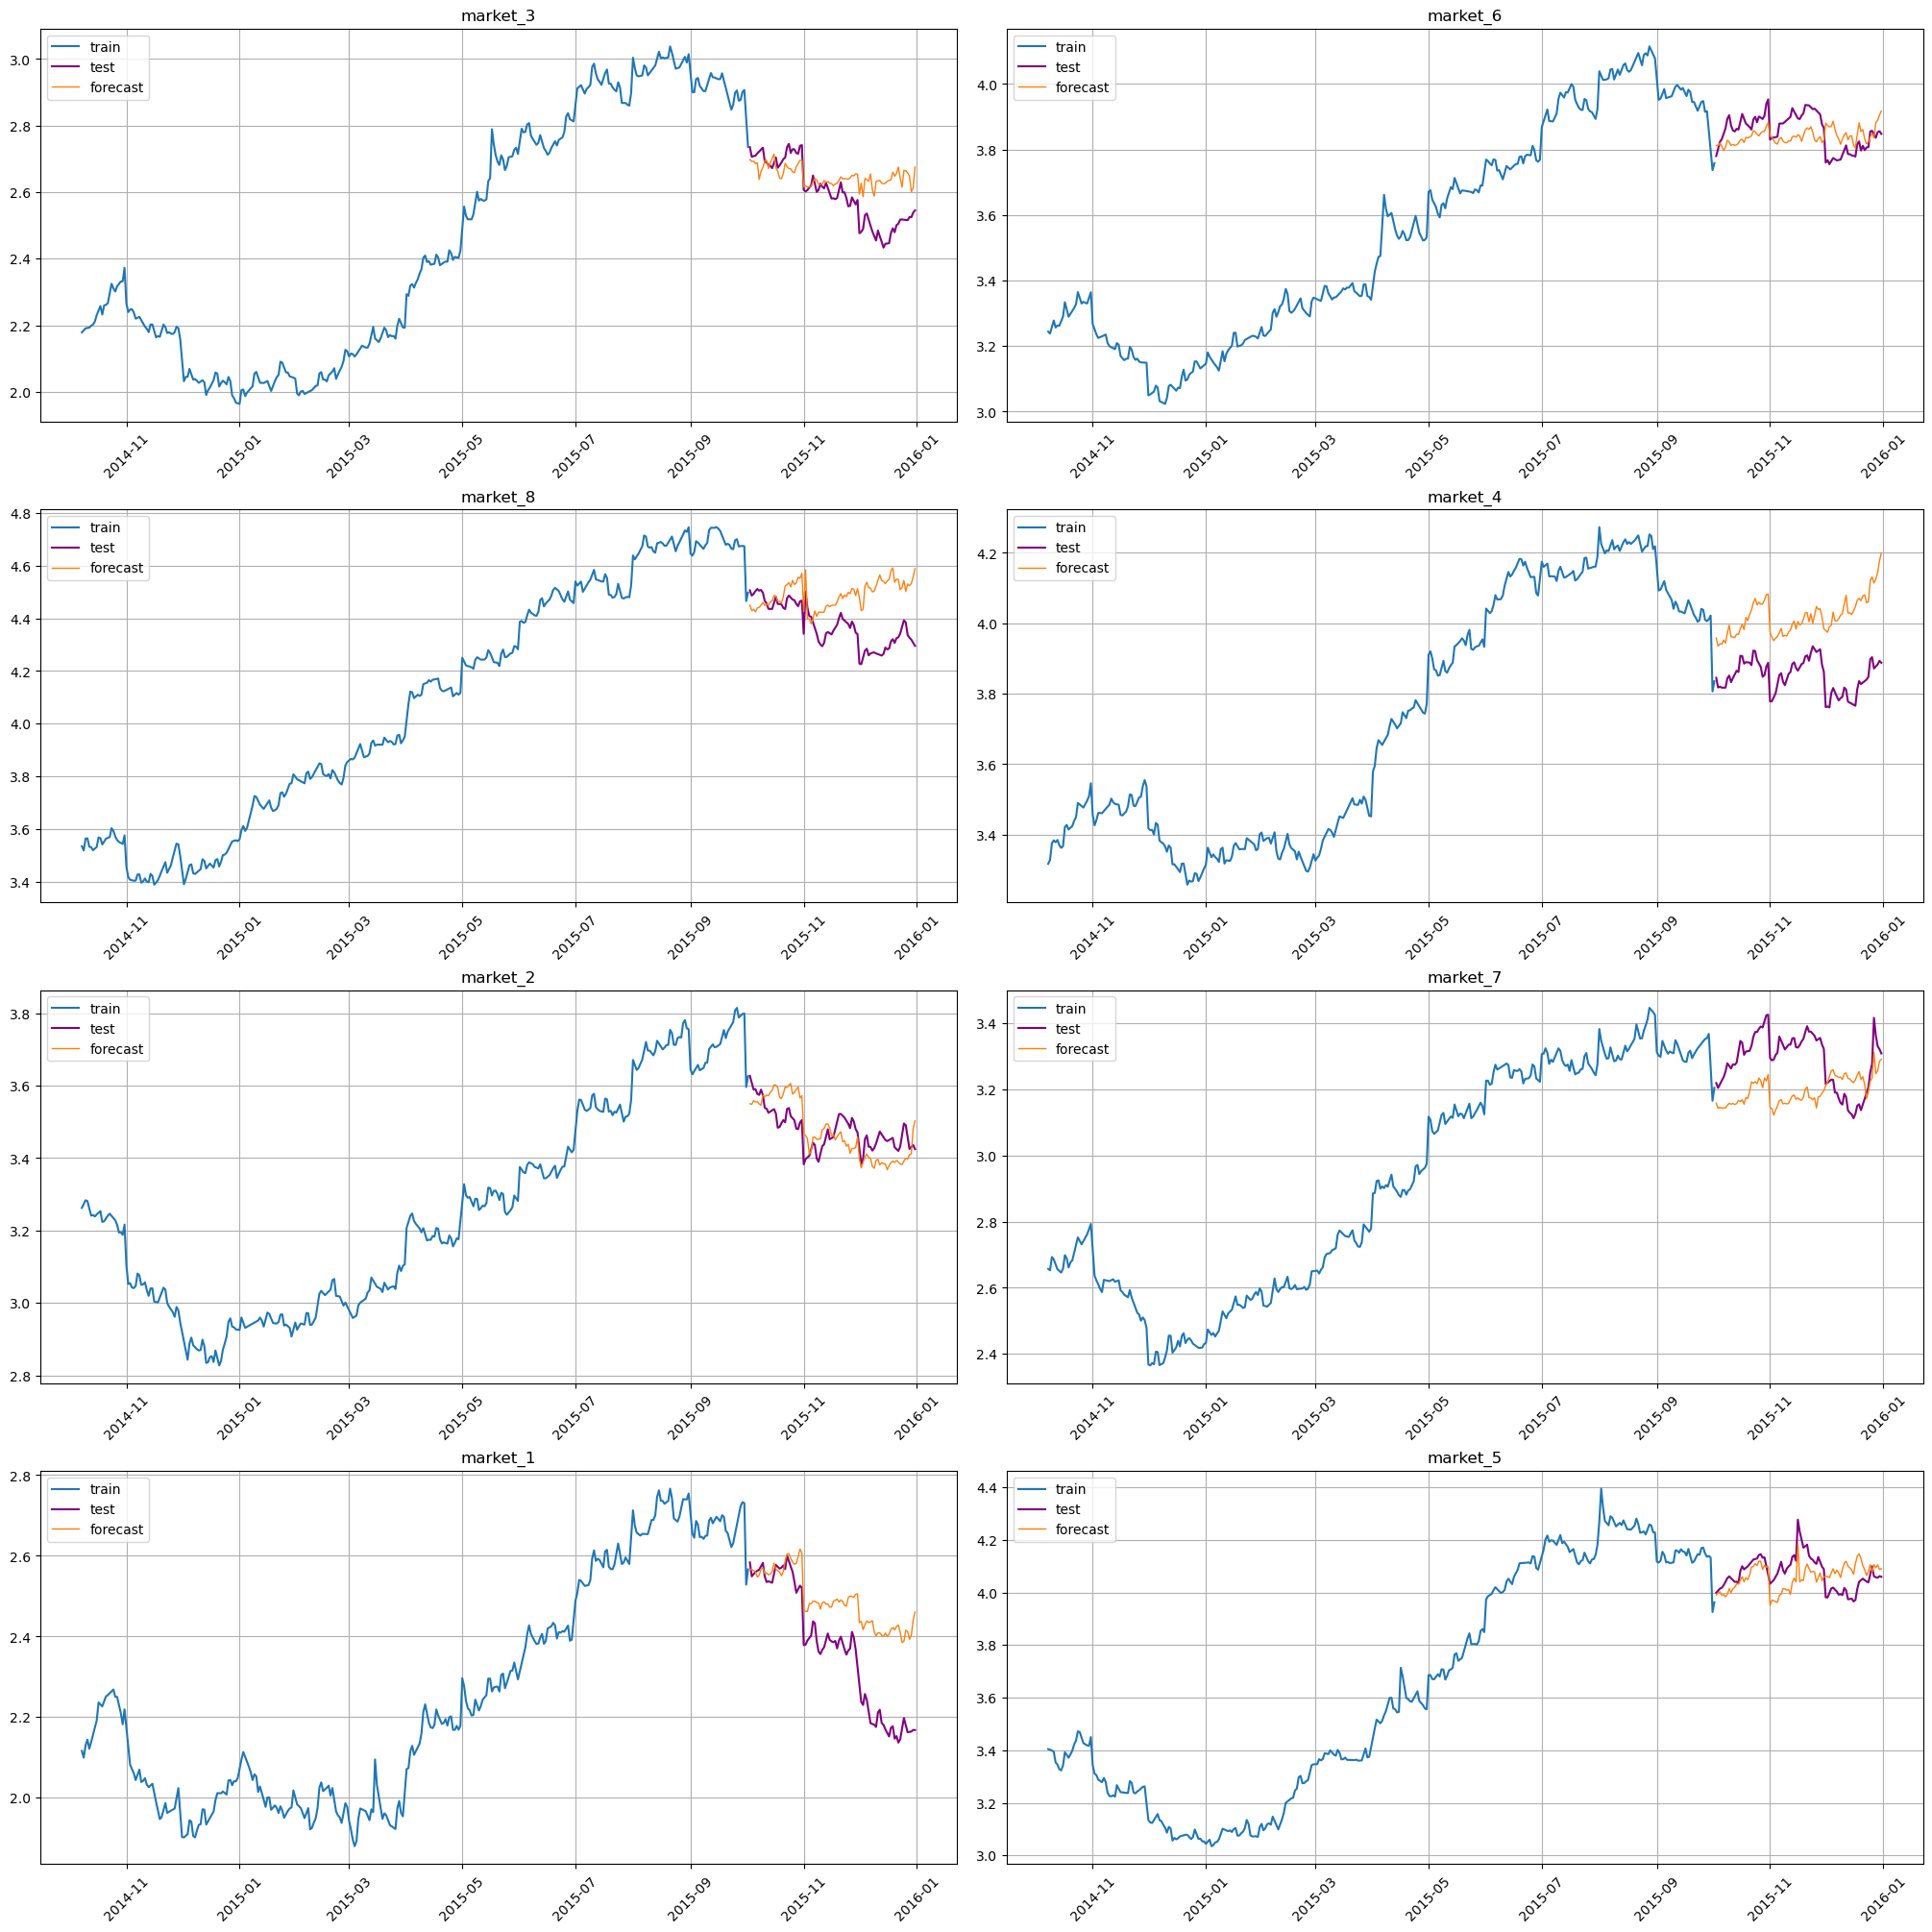

In [14]:
# визуализируем прогнозы для тестового набора, 
# здесь n_train_samples - n последних наблюдений 
# в обучающем наборе
plot_forecast(ctbst_forecast_ts, test_ts, 
              train_ts, n_train_samples=360)

In [15]:
# функция, создающая исторический набор
def hist_dataloader(internal_hist_path,
                    external_hist_path,
                    external_new_path,
                    horizon=90,
                    freq='D',
                    verbose=False):
    # загружаем исторические данные о продажах
    hist_sales = pd.read_csv(internal_hist_path, index_col=['date'], 
                             parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о продажах')
        display(hist_sales)
        
    # загружаем исторические данные о рекламной активности
    hist_advert = pd.read_csv(external_hist_path, parse_dates=['date'])
    
    if verbose:
        print('загружаем исторические данные о рекламной активности')
        display(hist_advert)
        
    # загружаем данные о рекламной активности в прогнозируемый период
    new_advert = pd.read_csv(external_new_path, parse_dates=['date'])
    
    if verbose:
        print('загружаем данные о рекламной активности в прогнозируемый период')
        display(new_advert)
         
    # берем первые 90 дней 2016 года из данных рекламной активности
    new_advert = new_advert.iloc[:horizon]
    
    if verbose:
        print('берем первые 90 дней 2016 года из данных рекламной активности')
        display(new_advert) 
        
    # заполним пропуски в исторических рядах продаж
    # с помощью линейной интерполяции
    for col in hist_sales.columns.tolist():
        hist_sales[col] = hist_sales[col].interpolate(method='linear')
        
    if verbose:
        print('заполним пропуски в исторических данных о продажах ' 
              'с помощью линейной интерполяции')
        display(hist_sales)
        
    # отбираем наблюдения с 2013 года и сбрасываем прежний индекс
    # в исторических данных о рекламной активности
    hist_sales = hist_sales[hist_sales.index >= '2013-01-01']
    hist_advert = hist_advert[hist_advert['date'] >= '2013-01-01'].reset_index(
        drop=True)
    
    if verbose:
        print('отбираем наблюдения с 2013 года и сбрасываем прежний \n'
              'индекс в исторических данных о рекламной активности')
        display(hist_sales, hist_advert)
    
    # выделим столбец с датой
    hist_sales['timestamp'] = hist_sales.index
    # сбрасываем прежний индекс
    hist_sales = hist_sales.reset_index(drop=True)
    
    if verbose:
        print('выделим столбец с датой в историческом наборе продаж '
              'и сбросим прежний индекс')
        display(hist_sales)
    
    # расплавляем исторический набор продаж в длинный датафрейм
    hist_sales_melt = hist_sales.melt(id_vars='timestamp', 
                                      var_name='segment', 
                                      value_name='target')
    
    if verbose:
        print('расплавляем исторический набор продаж в длинный датафрейм')
        display(hist_sales_melt)
        
    # переводим исторический набор продаж в формат ETNA
    hist_ts_format = TSDataset.to_dataset(hist_sales_melt)
    
    if verbose:
        print('переводим исторический набор продаж в формат ETNA')
        display(hist_ts_format)
        
    # конкатенируем исторические данные по рекламной активности 
    # и данные по рекламной активности в прогнозируемый период
    advert = pd.concat([hist_advert, new_advert], 
                       axis=0, ignore_index=True)
    # переименовываем date в timestamp
    advert.rename(columns={'date': 'timestamp'}, inplace=True)
    
    if verbose:
        print('конкатенируем исторические данные по рекламной активности '
              'и данные по рекламной активности в прогнозируемый период, '
              'переименовываем date в timestamp')
        display(advert)
      
    # расплавляем объединенные данные о рекламной 
    # активности в длинный датафрейм
    advert_melt = advert.melt(id_vars='timestamp', 
                              var_name='segment', 
                              value_name='advert')
    
    if verbose:
        print('расплавляем объединенные данные о рекламной '
              'активности в длинный датафрейм')
        display(advert_melt)
        
    # создаем переменную - квартал, начало и конец квартала
    advert_melt['quarter'] = advert_melt['timestamp'].dt.quarter
    # создаем переменную – начало квартала
    advert_melt['quarter_start'] = advert_melt[
        'timestamp'
    ].dt.is_quarter_start
    # создаем переменную – конец квартала
    advert_melt['quarter_end'] = advert_melt['timestamp'].dt.is_quarter_end
    # создаем переменную - название месяца
    advert_melt['month_name'] = advert_melt['timestamp'].dt.strftime('%b')
    advert_melt['month_name'] = advert_melt['month_name'].astype('category')
    
    if verbose:
        print('создаем календарные признаки в объединенных данных '
              'о рекламной активности')
        display(advert_melt)
    
    # переводим набор экзогенных переменных (рекламная
    # активность, календарные признаки) в формат ETNA
    df_regressors_ts_format = TSDataset.to_dataset(advert_melt)
    
    if verbose:
        print('переводим набор с экзогенными переменными (рекламная '
              'активность, календарные признаки) в формат ETNA')
        display(df_regressors_ts_format)
        
    # создаем итоговый исторический набор данных как объект TSDataset
    hist_ts = TSDataset(
        hist_ts_format, freq=freq, 
        df_exog=df_regressors_ts_format, known_future='all')
    
    if verbose:
        print('создаем итоговый исторический набор как объект TSDataset')
        display(hist_ts)
        
    return hist_ts

In [16]:
# создаем исторический набор
hist_ts = hist_dataloader(
    # путь к историческому набору эндогенных переменных
    internal_hist_path='Data/raif/sales_train.csv', 
    # путь к историческому набору экзогенных переменных
    external_hist_path='Data/raif/advert_train.csv', 
    # путь к набору экзогенных переменных
    # для прогнозируемого периода
    external_new_path='Data/raif/advert_test.csv', 
    horizon=HORIZON,
    freq='D',
    verbose=True)

загружаем исторические данные о продажах


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,NaN,1.006943,1.002595,1.006953,1.014819,NaN,1.008989,1.003241
2008-01-04,1.015188,NaN,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,NaN,1.045076,NaN,1.080214,1.071665,NaN,NaN,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,NaN,2.515498,3.871723,4.061596,NaN,3.416342,4.336864
2015-12-28,NaN,3.425255,2.525145,NaN,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,NaN,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235


загружаем исторические данные о рекламной активности


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,0,0,0,0,0,0,0,0
1,2008-01-03,0,0,0,0,0,0,0,0
2,2008-01-04,0,0,0,0,0,0,0,0
3,2008-01-05,0,0,0,0,0,0,0,0
4,2008-01-06,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2916,2015-12-27,0,0,0,0,0,0,1,0
2917,2015-12-28,0,0,0,0,0,0,0,0
2918,2015-12-29,0,0,0,0,0,0,0,0
2919,2015-12-30,0,0,0,0,0,0,0,0


загружаем данные о рекламной активности в прогнозируемый период


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2016-01-01,0,0,0,0,0,0,0,0
1,2016-01-02,0,0,0,0,0,0,0,0
2,2016-01-03,0,0,0,0,0,0,0,0
3,2016-01-04,0,0,0,0,0,0,0,0
4,2016-01-05,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
724,2017-12-25,0,0,0,0,0,0,0,0
725,2017-12-26,0,0,0,0,0,0,0,0
726,2017-12-27,0,0,0,0,0,0,0,0
727,2017-12-28,0,0,0,0,0,0,0,0


берем первые 90 дней 2016 года из данных рекламной активности


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2016-01-01,0,0,0,0,0,0,0,0
1,2016-01-02,0,0,0,0,0,0,0,0
2,2016-01-03,0,0,0,0,0,0,0,0
3,2016-01-04,0,0,0,0,0,0,0,0
4,2016-01-05,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
85,2016-03-26,0,0,0,0,0,0,0,0
86,2016-03-27,0,0,0,0,0,0,0,0
87,2016-03-28,0,0,0,0,0,0,0,0
88,2016-03-29,0,0,0,0,0,0,0,0


заполним пропуски в исторических данных о продажах с помощью линейной интерполяции


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,1.007594,1.006943,1.002595,1.006953,1.014819,1.012754,1.008989,1.003241
2008-01-04,1.015188,1.026009,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,1.005475,1.045076,1.047584,1.080214,1.071665,1.014202,1.032438,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235


отбираем наблюдения с 2013 года и сбрасываем прежний 
индекс в исторических данных о рекламной активности


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631
2015-12-29,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235


,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2013-01-01,0,0,0,0,0,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0
2,2013-01-03,0,0,0,0,0,0,0,0
3,2013-01-04,0,0,0,0,0,0,0,0
4,2013-01-05,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1090,2015-12-27,0,0,0,0,0,0,1,0
1091,2015-12-28,0,0,0,0,0,0,0,0
1092,2015-12-29,0,0,0,0,0,0,0,0
1093,2015-12-30,0,0,0,0,0,0,0,0


выделим столбец с датой в историческом наборе продаж и сбросим прежний индекс


,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
0,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802,2013-01-01
1,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513,2013-01-02
2,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439,2013-01-03
3,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610,2013-01-04
4,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781,2013-01-05
...,...,...,...,...,...,...,...,...,...
1090,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864,2015-12-27
1091,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631,2015-12-28
1092,2.164239,3.430501,2.524327,3.883184,4.056121,3.852841,3.330472,4.319235,2015-12-29
1093,2.168029,3.435747,2.538544,3.893227,4.062142,3.855567,3.321401,4.307126,2015-12-30


расплавляем исторический набор продаж в длинный датафрейм


,timestamp,segment,target
0,2013-01-01,market_1,1.709516
1,2013-01-02,market_1,1.717525
2,2013-01-03,market_1,1.723990
3,2013-01-04,market_1,1.750044
4,2013-01-05,market_1,1.731752
...,...,...,...
8755,2015-12-27,market_8,4.336864
8756,2015-12-28,market_8,4.326631
8757,2015-12-29,market_8,4.319235
8758,2015-12-30,market_8,4.307126


переводим исторический набор продаж в формат ETNA


segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2013-01-01,1.709516,2.318572,1.721826,2.190858,2.163801,2.156222,1.672642,2.697802
2013-01-02,1.717525,2.329281,1.721189,2.195295,2.168168,2.175232,1.685756,2.704513
2013-01-03,1.723990,2.339989,1.719877,2.198767,2.182105,2.186773,1.698870,2.699439
2013-01-04,1.750044,2.350698,1.752980,2.202239,2.196042,2.227879,1.711984,2.695610
2013-01-05,1.731752,2.346491,1.759707,2.186557,2.193507,2.218857,1.701571,2.691781
...,...,...,...,...,...,...,...,...
2015-12-27,2.162458,3.457937,2.515498,3.871723,4.061596,3.846346,3.416342,4.336864
2015-12-28,2.163348,3.425255,2.525145,3.877453,4.057857,3.835661,3.363259,4.326631


конкатенируем исторические данные по рекламной активности и данные по рекламной активности в прогнозируемый период, переименовываем date в timestamp


,timestamp,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2013-01-01,0,0,0,0,0,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0
2,2013-01-03,0,0,0,0,0,0,0,0
3,2013-01-04,0,0,0,0,0,0,0,0
4,2013-01-05,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1180,2016-03-26,0,0,0,0,0,0,0,0
1181,2016-03-27,0,0,0,0,0,0,0,0
1182,2016-03-28,0,0,0,0,0,0,0,0
1183,2016-03-29,0,0,0,0,0,0,0,0


расплавляем объединенные данные о рекламной активности в длинный датафрейм


,timestamp,segment,advert
0,2013-01-01,market_1,0
1,2013-01-02,market_1,0
2,2013-01-03,market_1,0
3,2013-01-04,market_1,0
4,2013-01-05,market_1,0
...,...,...,...
9475,2016-03-26,market_8,0
9476,2016-03-27,market_8,0
9477,2016-03-28,market_8,0
9478,2016-03-29,market_8,0


создаем календарные признаки в объединенных данных о рекламной активности


,timestamp,segment,advert,quarter,quarter_start,quarter_end,month_name
0,2013-01-01,market_1,0,1,True,False,Jan
1,2013-01-02,market_1,0,1,False,False,Jan
2,2013-01-03,market_1,0,1,False,False,Jan
3,2013-01-04,market_1,0,1,False,False,Jan
4,2013-01-05,market_1,0,1,False,False,Jan
...,...,...,...,...,...,...,...
9475,2016-03-26,market_8,0,1,False,False,Mar
9476,2016-03-27,market_8,0,1,False,False,Mar
9477,2016-03-28,market_8,0,1,False,False,Mar
9478,2016-03-29,market_8,0,1,False,False,Mar


переводим набор с экзогенными переменными (рекламная активность, календарные признаки) в формат ETNA


segment    market_1                                              market_2  \
feature      advert month_name quarter quarter_end quarter_start   advert   
timestamp                                                                   
2013-01-01        0        Jan       1       False          True        0   
2013-01-02        0        Jan       1       False         False        0   
2013-01-03        0        Jan       1       False         False        0   
2013-01-04        0        Jan       1       False         False        0   
2013-01-05        0        Jan       1       False         False        0   
...             ...        ...     ...         ...           ...      ...   
2016-03-26        0        Mar       1       False         False        0   
2016-03-27        0        Mar       1       False         False        0   
2016-03-28        0        Mar       1       False         False        0   
2016-03-29        0        Mar       1       False         False        0   
2016-03-30        0        Mar       1       False         False        0   

segment                                                 market_3             \
feature    month_name quarter quarter_end quarter_start   advert month_name   
timestamp                                                                     
2013-01-01        Jan       1       False          True        0        Jan   
2013-01-02        Jan       1       False         False        0        Jan   
2013-01-03        Jan       1       False         False        0        Jan   
2013-01-04        Jan       1       False         False        0        Jan   
2013-01-05        Jan       1       False         False        0        Jan   
...               ...     ...         ...           ...      ...        ...   
2016-03-26        Mar       1       False         False        0        Mar   
2016-03-27        Mar       1       False         False        0        Mar   
2016-03-28        Mar       1       False         False        0        Mar   
2016-03-29        Mar       1       False         False        0        Mar   
2016-03-30        Mar       1       False         False        0        Mar   

segment                                      market_4                     \
feature    quarter quarter_end quarter_start   advert month_name quarter   
timestamp                                                                  
2013-01-01       1       False          True        0        Jan       1   
2013-01-02       1       False         False        0        Jan       1   
2013-01-03       1       False         False        0        Jan       1   
2013-01-04       1       False         False        0        Jan       1   
2013-01-05       1       False         False        0        Jan       1   
...            ...         ...           ...      ...        ...     ...   
2016-03-26       1       False         False        0        Mar       1   
2016-03-27       1       False         False        0        Mar       1   
2016-03-28       1       False         False        0        Mar       1   
2016-03-29       1       False         False        0        Mar       1   
2016-03-30       1       False         False        0        Mar       1   

segment                              market_5                                 \
feature    quarter_end quarter_start   advert month_name quarter quarter_end   
timestamp                                                                      
2013-01-01       False          True        0        Jan       1       False   
2013-01-02       False         False        0        Jan       1       False   
2013-01-03       False         False        0        Jan       1       False   
2013-01-04       False         False        0        Jan       1       False   
2013-01-05       False         False        0        Jan       1       False   
...                ...           ...      ...        ...     ...         ...   
2016-03-26       False       

создаем итоговый исторический набор как объект TSDataset


segment    market_1                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.709516   
2013-01-02        0        Jan       1       False         False  1.717525   
2013-01-03        0        Jan       1       False         False  1.723990   
2013-01-04        0        Jan       1       False         False  1.750044   
2013-01-05        0        Jan       1       False         False  1.731752   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.162458   
2015-12-28        0        Dec       4       False         False  2.163348   
2015-12-29        0        Dec       4       False         False  2.164239   
2015-12-30        0        Dec       4       False         False  2.168029   
2015-12-31        0        Dec       4        True         False  2.168029   

segment    market_2                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.318572   
2013-01-02        0        Jan       1       False         False  2.329281   
2013-01-03        0        Jan       1       False         False  2.339989   
2013-01-04        0        Jan       1       False         False  2.350698   
2013-01-05        0        Jan       1       False         False  2.346491   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  3.457937   
2015-12-28        0        Dec       4       False         False  3.425255   
2015-12-29        0        Dec       4       False         False  3.430501   
2015-12-30        0        Dec       4       False         False  3.435747   
2015-12-31        0        Dec       4        True         False  3.424718   

segment    market_3                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.721826   
2013-01-02        0        Jan       1       False         False  1.721189   
2013-01-03        0        Jan       1       False         False  1.719877   
2013-01-04        0        Jan       1       False         False  1.752980   
2013-01-05        0        Jan       1       False         False  1.759707   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.515498   
2015-12-28        0        Dec       4       False         False  2.525145   
2015-12-29        0        Dec       4       False         False  2.524327   
2015-12-30        0        Dec       4       False         False  2.538544   
2015-12-31        0        Dec       4        True         False  2.545287   

segment    market_4                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.190858   
2013-01-02        0        Jan       1       False         False  2.195295   
2013-01-03        0        Jan       1       False         False  2.198767   
2013-01-04        0        Jan       1       False         False  2.202239   
2013-01-05        0        Jan       1       False         False  2.186557   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0

In [17]:
# выполняем преобразования всего исторического набора
hist_ts.fit_transform(train_preprocess)
hist_ts

segment                                                                 market_1  \
feature    LagTransform(in_column = 'target', lags = [117], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           1.042882                      
2015-12-28                                           0.899683                      
2015-12-29                                           0.867757                      
2015-12-30                                           0.984183                      
2015-12-31                                           0.956214                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [144], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.949057                      
2015-12-28                                           0.959204                      
2015-12-29                                           0.956241                      
2015-12-30                                           0.953278                      
2015-12-31                                           0.950315                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [171], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.688896                      
2015-12-28                                           0.844378                      
2015-12-29                                           0.900324                      
2015-12-30                                           0.822415                      
2015-12-31                                           0.834785                      

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [90], out_column = None, )   
timestamp                                                                         
2013-01-01                                                NaN                     
2013-01-02                                                NaN                     
2013-01-03                                            

In [18]:
# смотрим описание исторического набора
hist_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
market_1,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_2,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_3,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_4,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_5,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_6,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_7,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_8,2013-01-01,2015-12-31,1095,0,8,16,15,5,D


In [19]:
# создаем экземпляр класса CatBoostMultiSegmentModel
ctbst_full_model = CatBoostMultiSegmentModel(
    iterations=500,
    depth=train_best_params.get('depth'))

# обучаем модель CatBoost на всем историческом наборе
ctbst_full_model.fit(hist_ts)

# формируем набор, для которого нужно получить прогнозы,
# длина набора определяется горизонтом прогнозирования,
# по сути мы формируем набор новых данных
ctbst_future_ts = hist_ts.make_future(HORIZON, train_preprocess)

# получаем прогнозы для новых данных
ctbst_forecast_ts = ctbst_full_model.forecast(ctbst_future_ts)

# выполняем обратные преобразования прогнозов
ctbst_forecast_ts.inverse_transform(train_preprocess)

In [20]:
# выполняем обратные преобразования для исторического набора
hist_ts.inverse_transform(train_preprocess)

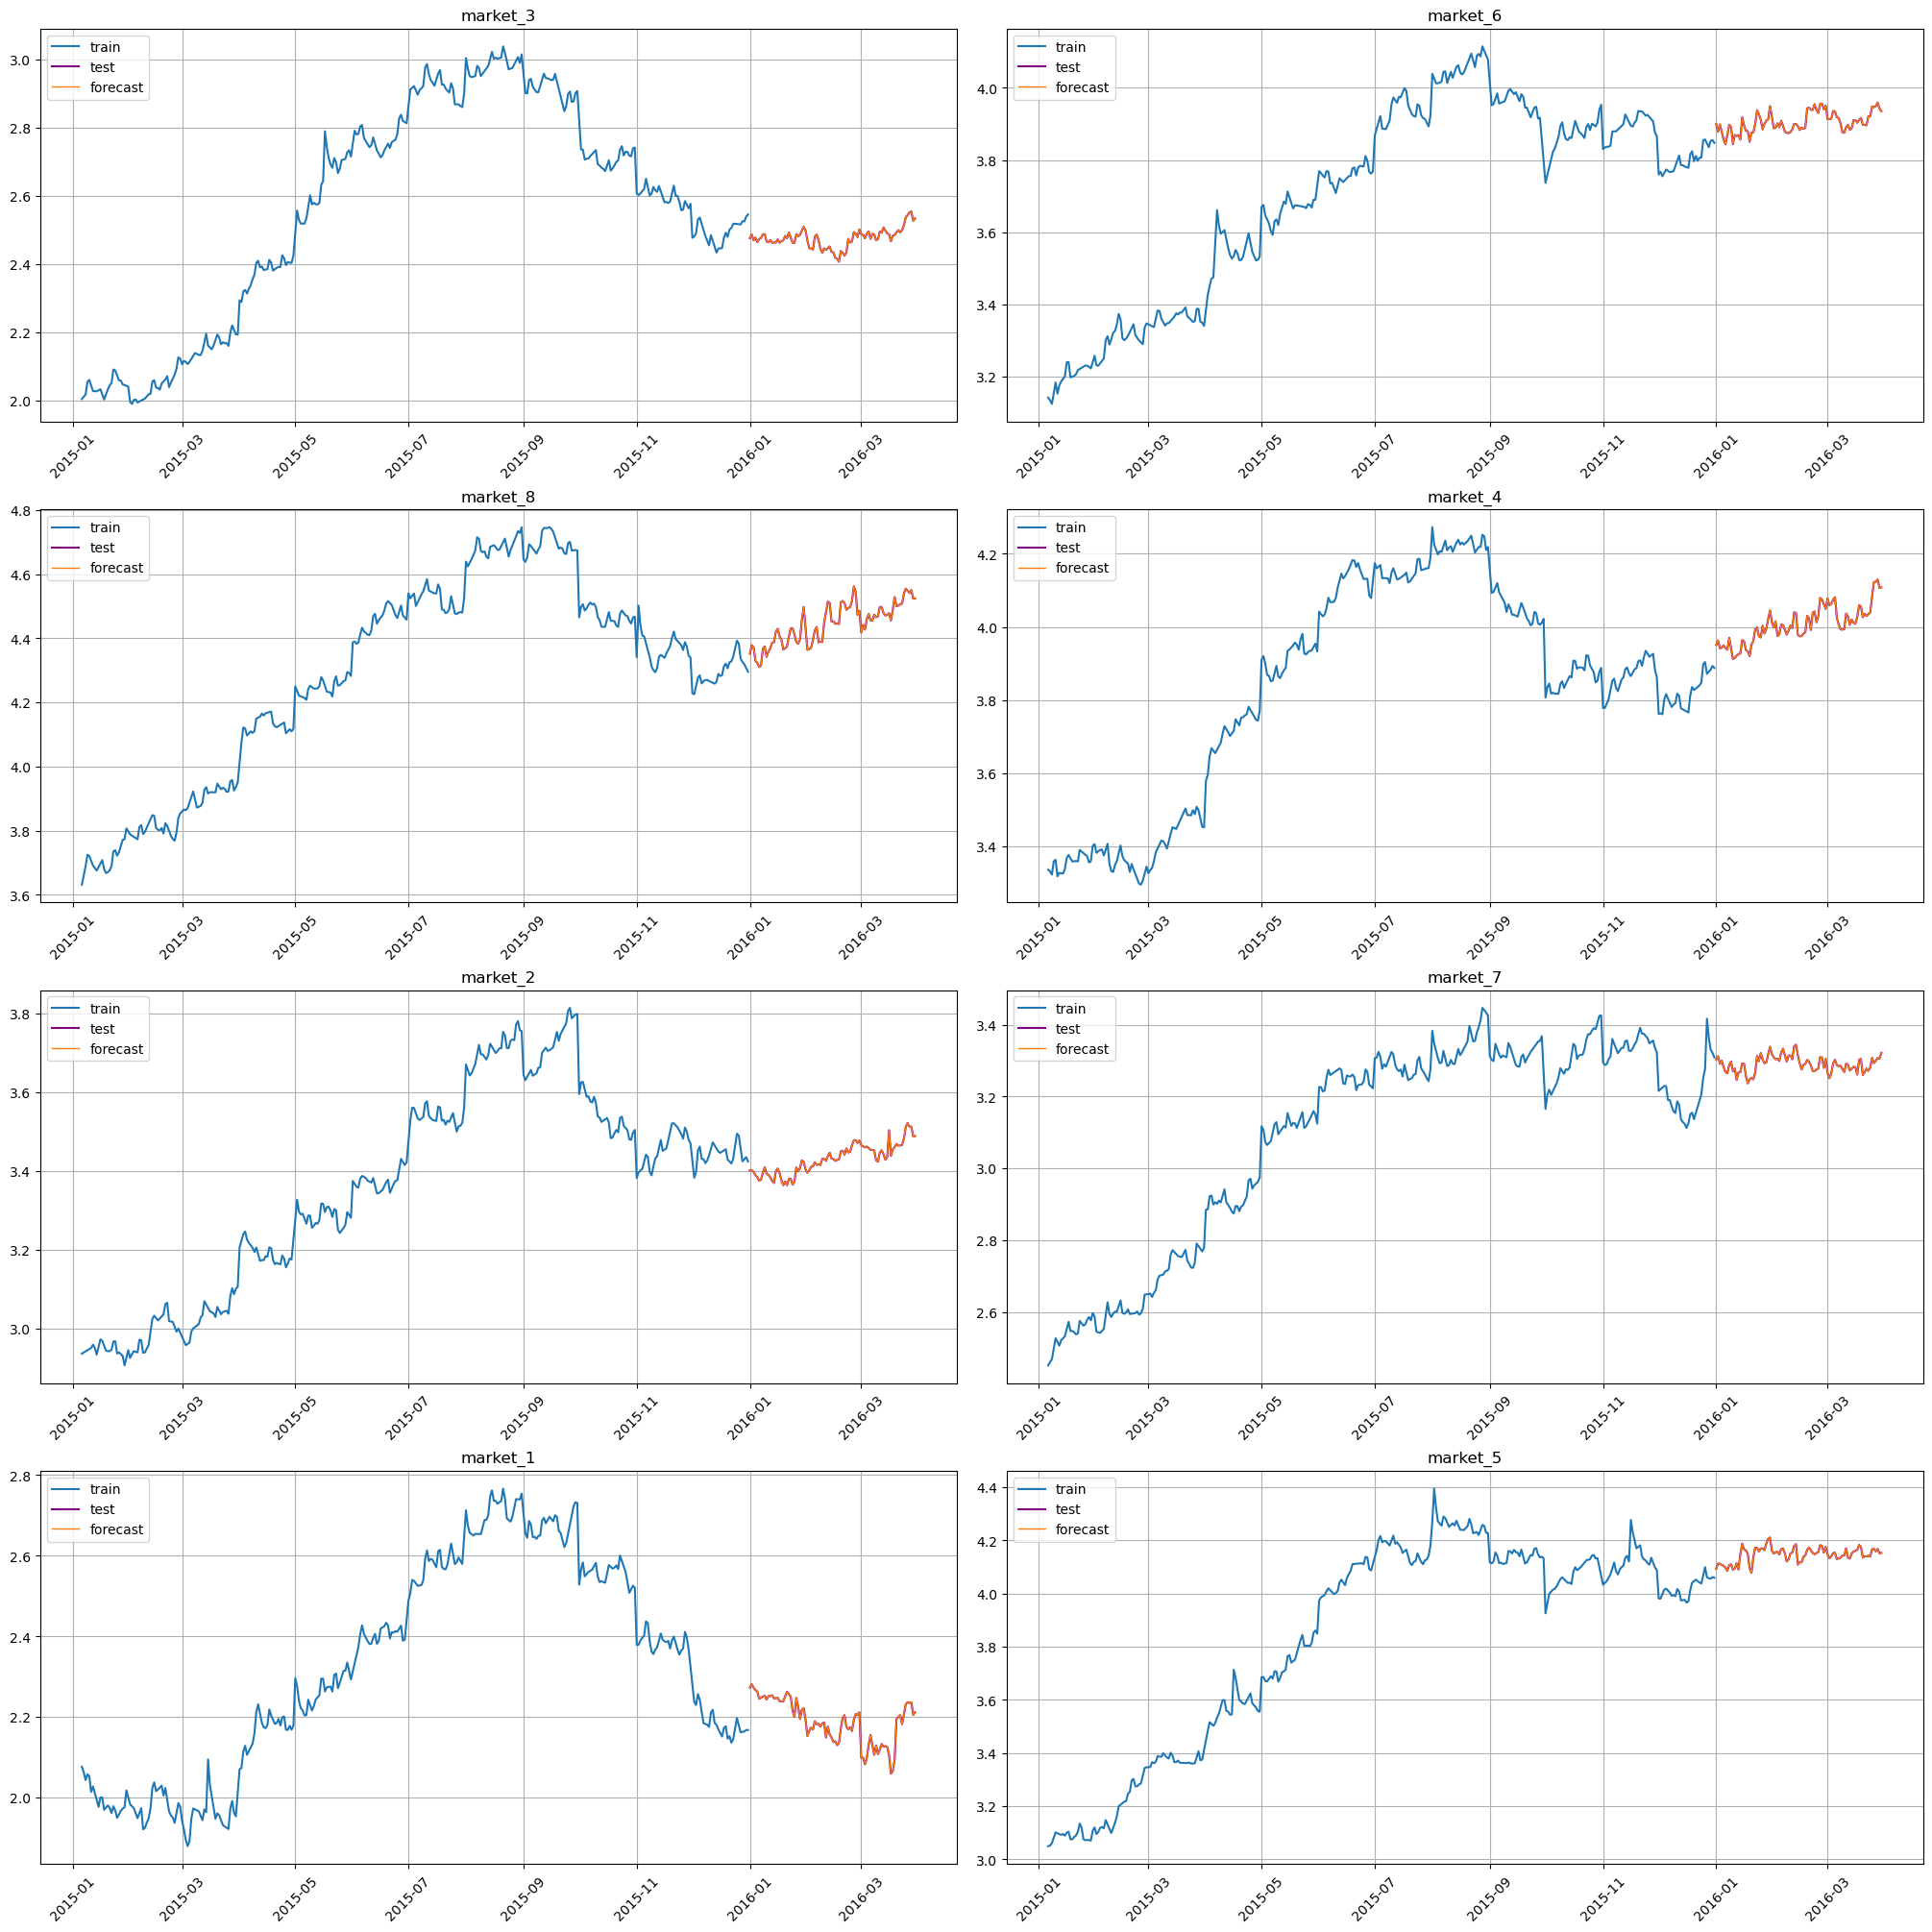

In [21]:
# визуализируем прогнозы для набора новых данных, 
# здесь n_train_samples - n последних наблюдений 
# в историческом наборе
plot_forecast(ctbst_forecast_ts, ctbst_future_ts, 
              hist_ts, n_train_samples=360)

## Оптимизация гиперпараметров без выделения отдельной тестовой выборки

In [22]:
# создаем исторический набор
hist_ts = hist_dataloader(
    # путь к историческому набору эндогенных переменных
    internal_hist_path='Data/raif/sales_train.csv', 
    # путь к историческому набору экзогенных переменных
    external_hist_path='Data/raif/advert_train.csv', 
    # путь к набору экзогенных переменных
    # для прогнозируемого периода
    external_new_path='Data/raif/advert_test.csv', 
    horizon=HORIZON,
    freq='D')
hist_ts

segment    market_1                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.709516   
2013-01-02        0        Jan       1       False         False  1.717525   
2013-01-03        0        Jan       1       False         False  1.723990   
2013-01-04        0        Jan       1       False         False  1.750044   
2013-01-05        0        Jan       1       False         False  1.731752   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.162458   
2015-12-28        0        Dec       4       False         False  2.163348   
2015-12-29        0        Dec       4       False         False  2.164239   
2015-12-30        0        Dec       4       False         False  2.168029   
2015-12-31        0        Dec       4        True         False  2.168029   

segment    market_2                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.318572   
2013-01-02        0        Jan       1       False         False  2.329281   
2013-01-03        0        Jan       1       False         False  2.339989   
2013-01-04        0        Jan       1       False         False  2.350698   
2013-01-05        0        Jan       1       False         False  2.346491   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  3.457937   
2015-12-28        0        Dec       4       False         False  3.425255   
2015-12-29        0        Dec       4       False         False  3.430501   
2015-12-30        0        Dec       4       False         False  3.435747   
2015-12-31        0        Dec       4        True         False  3.424718   

segment    market_3                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  1.721826   
2013-01-02        0        Jan       1       False         False  1.721189   
2013-01-03        0        Jan       1       False         False  1.719877   
2013-01-04        0        Jan       1       False         False  1.752980   
2013-01-05        0        Jan       1       False         False  1.759707   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0        Dec       4       False         False  2.515498   
2015-12-28        0        Dec       4       False         False  2.525145   
2015-12-29        0        Dec       4       False         False  2.524327   
2015-12-30        0        Dec       4       False         False  2.538544   
2015-12-31        0        Dec       4        True         False  2.545287   

segment    market_4                                                         \
feature      advert month_name quarter quarter_end quarter_start    target   
timestamp                                                                    
2013-01-01        0        Jan       1       False          True  2.190858   
2013-01-02        0        Jan       1       False         False  2.195295   
2013-01-03        0        Jan       1       False         False  2.198767   
2013-01-04        0        Jan       1       False         False  2.202239   
2013-01-05        0        Jan       1       False         False  2.186557   
...             ...        ...     ...         ...           ...       ...   
2015-12-27        0

In [23]:
# вызов функции run_optuna, запуск оптимизации
hist_best_params = run_optuna(ts=hist_ts, 
                              horizon=HORIZON, 
                              metrics=SMAPE(),
                              n_trials=5)
hist_best_params

[I 2023-12-12 22:13:27,653] A new study created in RDB with name: no-name-92a4ad6c-a0bf-46eb-bec0-62e73c482f6e
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 97, 104, 111, 118, 125, 132, 139, 146, 153, 160, 167, 174, 181, 188, 195, 202, 209, 216, 223, 230, 237, 244, 251, 258, 265, 272, 279, 286, 293, 300, 307, 314], out_column = None, ), MeanTransform(in_column = 'target', window = 160, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elaps

метрика по сегментам:
    segment     SMAPE
0  market_1  5.325528
1  market_2  2.658754
2  market_3  5.954725
3  market_4  4.566135
4  market_5  5.223824
5  market_6  4.310320
6  market_7  4.422255
7  market_8  4.414528

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 3, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 112, 134, 156, 178, 200, 222, 244], out_column = None, ), MeanTransform(in_column = 'target', window = 240, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_wee

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  5.106757
1  market_2  2.730600
2  market_3  5.406816
3  market_4  5.071791
4  market_5  4.825702
5  market_6  4.436813
6  market_7  4.624745
7  market_8  5.371816

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 108, 126, 144, 162, 180], out_column = None, ), MeanTransform(in_column = 'target', window = 228, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  4.596220
1  market_2  2.763723
2  market_3  5.253216
3  market_4  5.008439
4  market_5  4.664486
5  market_6  4.145039
6  market_7  4.990054
7  market_8  5.757105

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 3, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 116, 142, 168, 194], out_column = None, ), MeanTransform(in_column = 'target', window = 187, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  5.288550
1  market_2  2.923158
2  market_3  5.360828
3  market_4  4.211502
4  market_5  5.147688
5  market_6  3.737927
6  market_7  5.228628
7  market_8  4.787141

конфигурация:
Pipeline(model = CatBoostMultiSegmentModel(iterations = 500, depth = 3, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), StandardScalerTransform(in_column = ['target'], inplace = True, out_column = None, with_mean = True, with_std = True, mode = 'per-segment', ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [90, 118, 146, 174], out_column = None, ), MeanTransform(in_column = 'target', window = 137, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

метрика по сегментам:
    segment     SMAPE
0  market_1  4.783068
1  market_2  2.697274
2  market_3  5.500854
3  market_4  3.865233
4  market_5  4.296434
5  market_6  3.250312
6  market_7  5.130733
7  market_8  4.687114


{'depth': 3, 'lag_step': 28, 'lag_upper_bound': 200, 'window_size': 137}

In [24]:
# создаем экземпляр класса LogTransform для логарифмирования 
# зависимой переменной
log = LogTransform(in_column='target')
    
# создаем экземпляр класса StandardScalerTransform
# для стандартизации зависимой переменной
scaler = StandardScalerTransform('target')
    
# создаем экземпляр класса LinearTrendTransform для прогнозирования 
# тренда, удаления тренда из даннных и добавления тренда к прогнозам
detrend = LinearTrendTransform(in_column='target')

# создаем экземпляр класса SegmentEncoderTransform для 
# кодирования меток сегментов целочисленными значениями 
# в лексикографическом порядке (LabelEncoding): сегменты
# a, b, c, d получат значения 0, 1, 2, 3
seg = SegmentEncoderTransform()
    
# создаем экземпляр класса LagTransform для генерации лагов
lag = LagTransform(
    in_column='target', 
    lags=list(range(HORIZON, 
                    hist_best_params.get('lag_upper_bound'), 
                    hist_best_params.get('lag_step')
                   )
    )
)
    
# создаем экземпляр класса MeanTransform 
# для генерации скользящих средних
mean = MeanTransform(in_column='target', 
                     window=hist_best_params.get('window_size'))
       
# создаем экземпляр класса DateFlagsTransform
# для генерации признаков на основе дат
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             month_number_in_year=True,
                             season_number=True,
                             is_weekend=True, 
                             out_column='datetime')

# формируем список преобразований/признаков    
hist_preprocess = [log, scaler, detrend, seg, lag, mean, d_flags]

In [25]:
# выполняем преобразования всего исторического набора
hist_ts.fit_transform(hist_preprocess)
hist_ts

segment                                                                 market_1  \
feature    LagTransform(in_column = 'target', lags = [118], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           1.184206                      
2015-12-28                                           1.042882                      
2015-12-29                                           0.899683                      
2015-12-30                                           0.867757                      
2015-12-31                                           0.984183                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [146], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.974291                      
2015-12-28                                           0.961679                      
2015-12-29                                           0.949057                      
2015-12-30                                           0.959204                      
2015-12-31                                           0.956241                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [174], out_column = None, )   
timestamp                                                                          
2013-01-01                                                NaN                      
2013-01-02                                                NaN                      
2013-01-03                                                NaN                      
2013-01-04                                                NaN                      
2013-01-05                                                NaN                      
...                                                       ...                      
2015-12-27                                           0.653900                      
2015-12-28                                           0.654843                      
2015-12-29                                           0.655785                      
2015-12-30                                           0.688896                      
2015-12-31                                           0.844378                      

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [90], out_column = None, )   
timestamp                                                                         
2013-01-01                                                NaN                     
2013-01-02                                                NaN                     
2013-01-03                                            

In [26]:
# смотрим описание исторического набора
hist_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
market_1,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_2,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_3,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_4,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_5,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_6,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_7,2013-01-01,2015-12-31,1095,0,8,16,15,5,D
market_8,2013-01-01,2015-12-31,1095,0,8,16,15,5,D


In [27]:
# создаем экземпляр класса CatBoostMultiSegmentModel
ctbst_full_model = CatBoostMultiSegmentModel(
    iterations=500,
    depth=hist_best_params.get('depth'))

# обучаем модель CatBoost на всем историческом наборе
ctbst_full_model.fit(hist_ts)

# формируем набор, для которого нужно получить прогнозы,
# длина набора определяется горизонтом прогнозирования,
# по сути мы формируем набор новых данных
ctbst_future_ts = hist_ts.make_future(HORIZON, hist_preprocess)

# получаем прогнозы для новых данных
ctbst_forecast_ts = ctbst_full_model.forecast(
    ctbst_future_ts)

# выполняем обратные преобразования прогнозов
ctbst_forecast_ts.inverse_transform(hist_preprocess)

In [28]:
# выполняем обратные преобразования для исторического набора
hist_ts.inverse_transform(hist_preprocess)

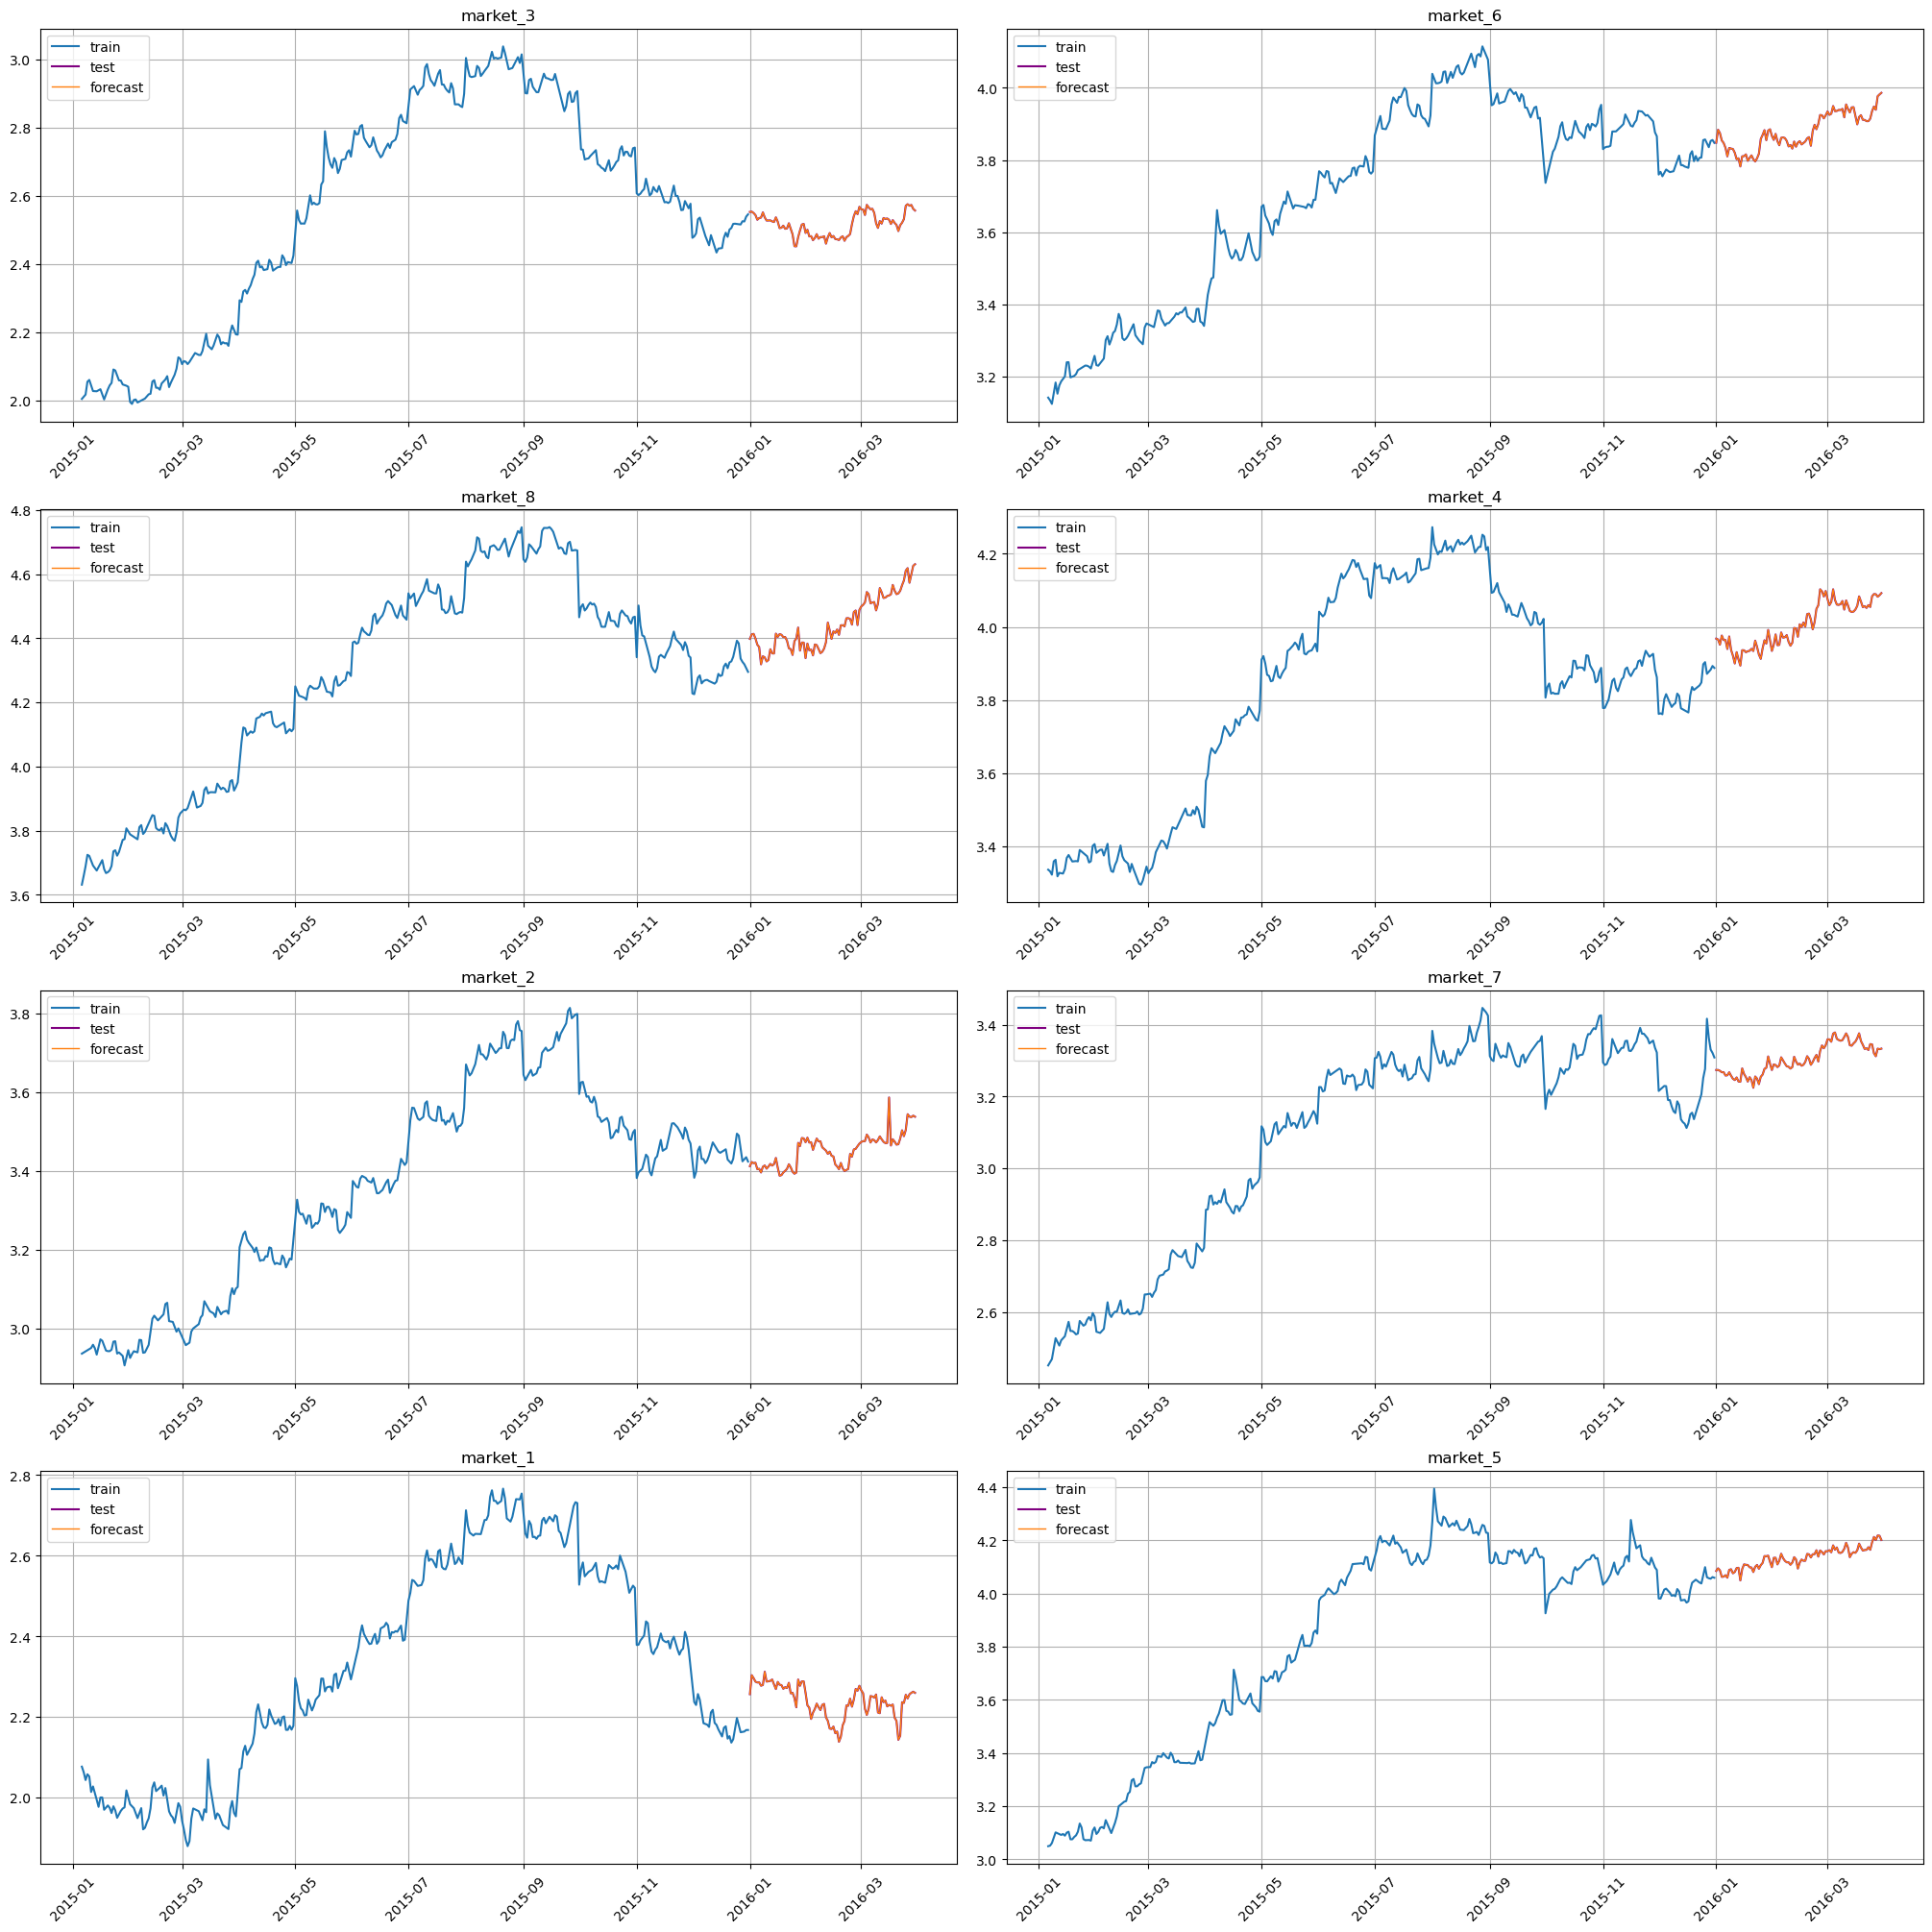

In [29]:
# визуализируем прогнозы для набора новых данных, 
# здесь n_train_samples - n последних наблюдений 
# в историческом наборе
plot_forecast(ctbst_forecast_ts, ctbst_future_ts, 
              hist_ts, n_train_samples=360)